In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# Download data

!wget https://fz-juelich.sciebo.de/s/lYkEFXONMdNLK7e/download -O data/cell_data.h5
!ls data

--2022-11-04 14:40:41--  https://fz-juelich.sciebo.de/s/lYkEFXONMdNLK7e/download
Resolving fz-juelich.sciebo.de (fz-juelich.sciebo.de)... 128.176.1.2
Connecting to fz-juelich.sciebo.de (fz-juelich.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2631491832 (2.5G) [application/octet-stream]
Saving to: ‘data/cell_data.h5’

data/cell_data.h5   100%[===================>]   2.45G   144MB/s    in 18s     

2022-11-04 14:41:00 (139 MB/s) - ‘data/cell_data.h5’ saved [2631491832/2631491832]

cell_data.h5


### Task 1

Plot the number of images per brain

In [2]:
import h5py as h5
import numpy as np
import pandas as pd
import seaborn as sns
from math import prod, sqrt
import matplotlib.pyplot as plt

In [3]:
# Load data and get image sizes

data_path = "data/cell_data.h5"

###

h5_file = h5.File(data_path, 'r')

sizes = []
brain_keys = []
image_keys = []
for b in h5_file.keys():
    for i, img in h5_file[b].items():
        sizes.append(prod(img.shape))
        brain_keys.append(b)
        image_keys.append(i)

data = pd.DataFrame({'brain': brain_keys, 'image': image_keys, 'img_size': sizes})
data.head()

,brain,image,img_size
0,B01,0000,386152
1,B01,0001,526500
2,B01,0002,544203
3,B01,0003,1798630
4,B01,0004,1685775


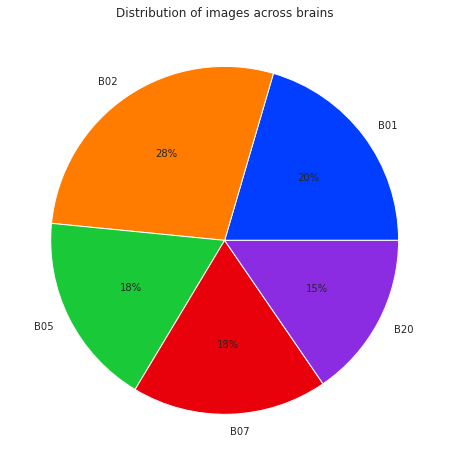

Total image count: 1348


In [4]:
# Plot fraction of images from each brain in a pie chart

image_counts = data.brain.value_counts(sort=False)

palette_color = sns.color_palette('bright')
plt.figure(figsize=(8, 8))
plt.pie(image_counts.values, labels=image_counts.index, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of images across brains")
plt.show()
print("Total image count:", image_counts.values.sum())

### Taks 2

Plot the distribution of image sizes in an interpretable way

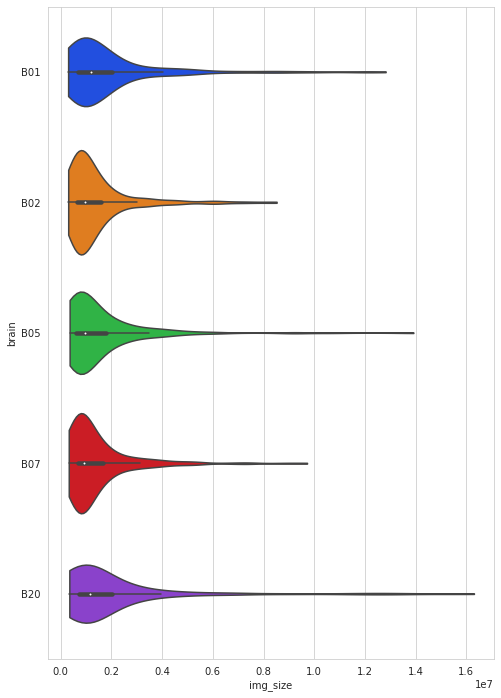

In [5]:
# Plot the distribution of image sizes per brain as violin plot

plt.figure(figsize=(8, 12))
sns.violinplot(data=data, x='img_size', y='brain', palette=palette_color, linewidth=1.5, cut=0)
plt.show()

### Task 3

Checkout the largest and smallest images per brain and visualize them.

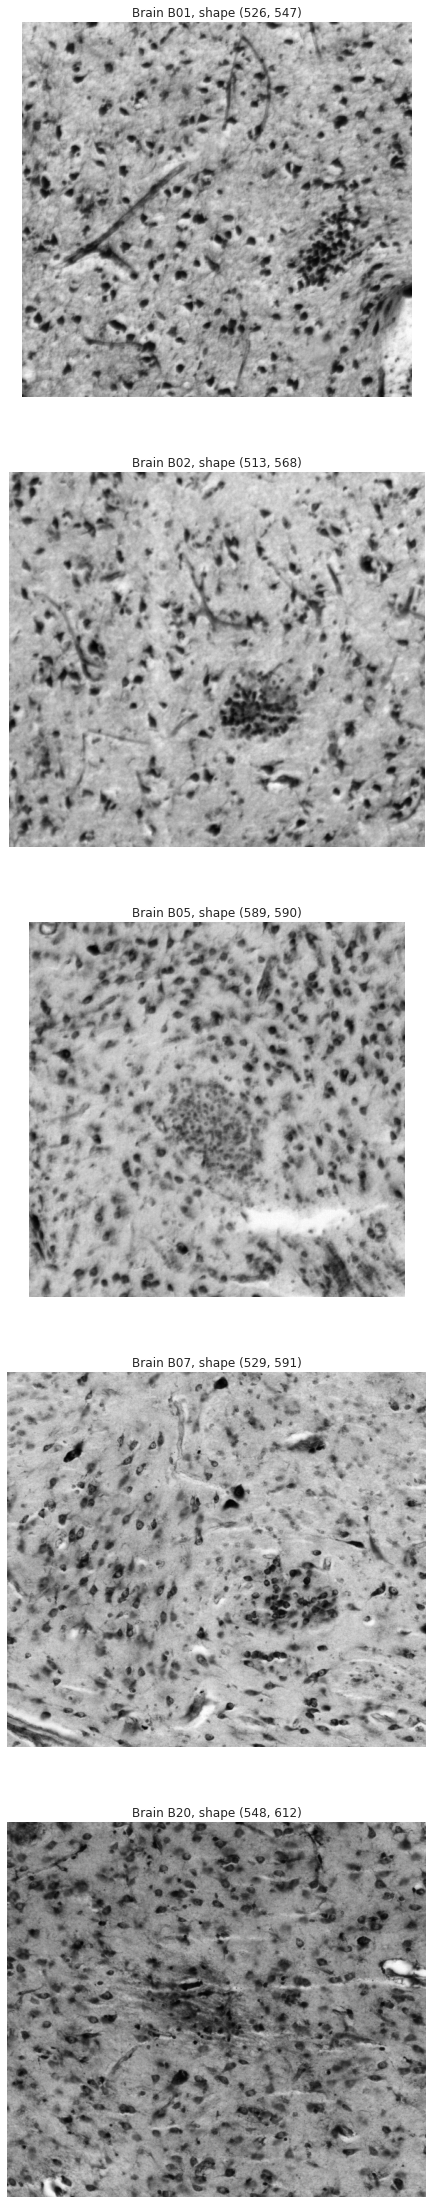

In [6]:
# Visualize the smallest images per brain

min_images = data[data.groupby(['brain'])['img_size'].transform(min) == data['img_size']]
n_images = len(min_images)

fig, axs = plt.subplots(nrows=n_images, figsize=(8, n_images * 8))
for a, (_, r) in zip(axs, min_images.iterrows()):
    img = h5_file[r.brain][r.image]
    a.imshow(img, cmap='gray')
    a.set_axis_off()
    a.set_title(f"Brain {r.brain}, shape {img.shape}")
plt.show()

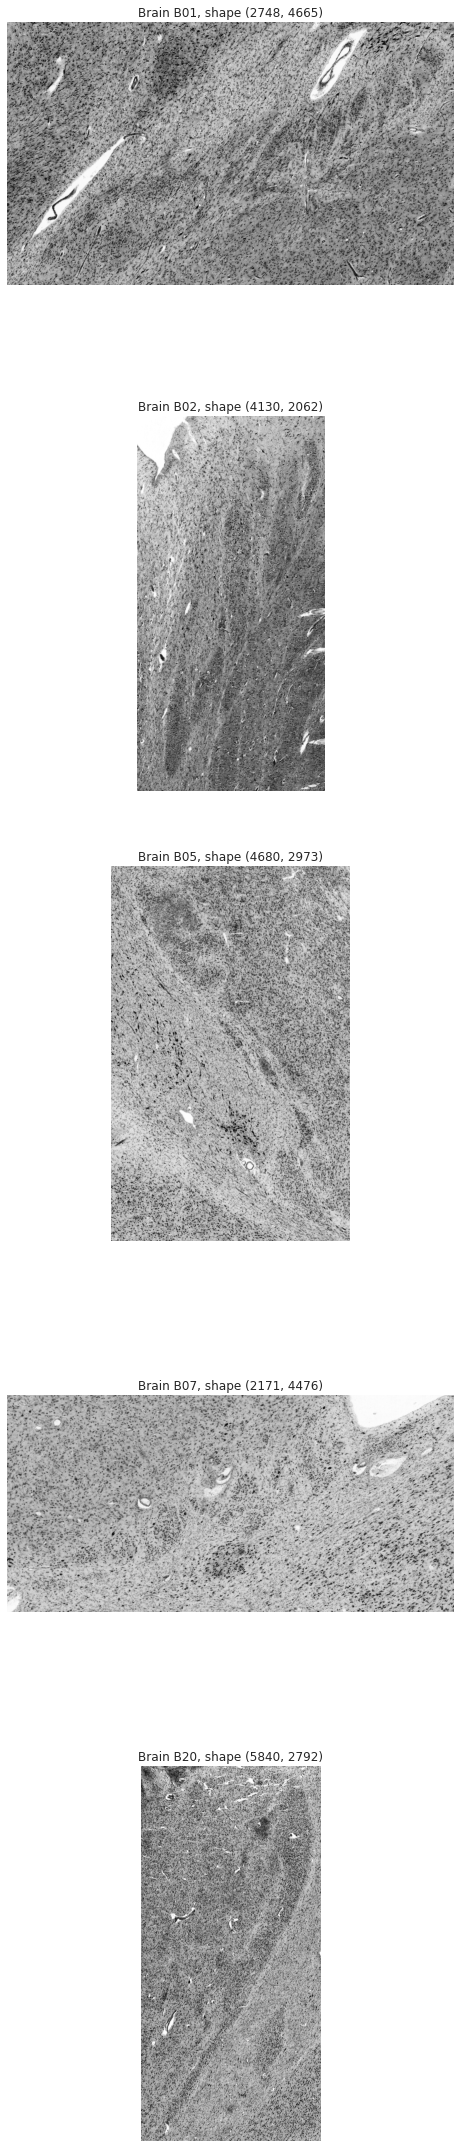

In [7]:
# Visualize the largest images per brain

max_images = data[data.groupby(['brain'])['img_size'].transform(max) == data['img_size']]
n_images = len(max_images)


fig, axs = plt.subplots(nrows=n_images, figsize=(8, n_images * 8))
for a, (_, r) in zip(axs, max_images.iterrows()):
    img = h5_file[r.brain][r.image]
    a.imshow(img, cmap='gray')
    a.set_axis_off()
    a.set_title(f"Brain {r.brain}, shape {img.shape}")
plt.show()

### Task 4

Based on your data exploration decide for one test brain group and keep the other groups for training.

In [8]:
train_brains = ['B02', 'B05', 'B07', 'B20']
test_brains = ['B01']

###

train_data = data[data.brain.isin(train_brains)]
test_data = data[data.brain.isin(test_brains)]

### Task 5

Determine and store the global maximum, minimum, mean and standard deviation for the image pixel values of the training data.

In [9]:
# Get min, max and mean per image

train_data = train_data.assign(img_max=0, img_min=0, img_mean=0., img_variance=0.)

for i, r in train_data.iterrows():
    img = h5_file[r.brain][r.image][:]
    train_data.loc[i, 'img_max'] = int(img.max())
    train_data.loc[i, 'img_min'] = int(img.min())
    train_data.loc[i, 'img_mean'] = int(img.mean())

train_data.head()

,brain,image,img_size,img_max,img_min,img_mean,img_variance
276,B02,0000,606006,253,10,151.0,0.0
277,B02,0001,1504954,255,12,166.0,0.0
278,B02,0002,639360,247,4,106.0,0.0
279,B02,0003,1085760,255,3,113.0,0.0
280,B02,0004,500284,248,12,151.0,0.0


In [10]:
# Get global max, min and mean

global_max = train_data.img_max.max()
global_min = train_data.img_min.min()
global_mean = (train_data.img_size * train_data.img_mean).sum() / train_data.img_size.sum()

print("Max:", global_max, '\tMin:', global_min, '\tMean:', global_mean)

Max: 255 	Min: 0 	Mean: 153.84735783843442


In [11]:
# Get variance per image

for i, r in train_data.iterrows():
    img = h5_file[r.brain][r.image][:]
    train_data.loc[i, 'img_variance'] = ((img - global_mean) ** 2).mean()

train_data.head()

,brain,image,img_size,img_max,img_min,img_mean,img_variance
276,B02,0000,606006,253,10,151.0,1171.331750
277,B02,0001,1504954,255,12,166.0,1355.075568
278,B02,0002,639360,247,4,106.0,3391.523355
279,B02,0003,1085760,255,3,113.0,3744.741419
280,B02,0004,500284,248,12,151.0,1406.280185


In [12]:
global_variance = (train_data.img_size * train_data.img_variance).sum() / train_data.img_size.sum()
global_std = sqrt(global_variance)

print("Variance:", global_variance, "\tStandard deviation", global_std)

Variance: 2413.9623051053545 	Standard deviation 49.132090379968105
